In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mnlogit
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pingouin as pg

# TODO START

index_col=0 - Убрали лишнюю колонку с индексами

In [13]:

df_cs = pd.read_csv("D:\Eduson_data\Customer Segmentation.csv", index_col=0)
print(df_cs.head())

'С пропусками количество наблюдений -> ', df_cs.shape


       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  460394  Female           No   32       Yes     Healthcare              9.0   
1  461798  Female           No   56       Yes         Artist              0.0   
2  464976    Male          Yes   75        No         Lawyer              1.0   
3  462104    Male          Yes   39        No  Entertainment              9.0   
4  464829    Male           No   22        No     Healthcare              9.0   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          3.0  Cat_6            D  
1            Low          1.0  Cat_6            A  
2            Low          1.0  Cat_4            D  
3            Low          2.0  Cat_3            D  
4            Low          5.0  Cat_4            D  


('С пропусками количество наблюдений -> ', (10695, 11))


**One-Way ANOVA ◾ ols ◾ groupby**

**notna()** — логическая маска
* Назначение: `проверка`, где нет `пропусков` (NaN).

* `Не изменяет` DataFrame.

* Возвращает объект `того же размера`, где `True` — значение `присутствует`.

In [46]:
# TODO создаём таблицу наблюдений с НЕ пропущенными  элементами в Graduated
df_cs = df_cs[df_cs.Graduated.notna()]

model = ols('Age ~ Segmentation', df_cs).fit()
print(anova_lm(model), '\n')
# model.summary()

'Без пропусков количество наблюдений -> ', df_cs.shape



                   df        sum_sq        mean_sq           F         PR(>F)
Segmentation      3.0  3.541179e+05  118039.307058  477.952227  2.798107e-291
Residual      10589.0  2.615153e+06     246.968840         NaN            NaN 



array([34.723     , 44.3633429 , 34.723     , ..., 44.3633429 ,
       44.3633429 , 47.66191275])

shapiro one-way

In [55]:
print(shapiro(model.resid))


ShapiroResult(statistic=0.9366268515586853, pvalue=0.0)


C:\Users\Kirill\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


QQ - plot one-way

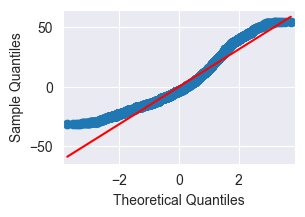

In [16]:
fig, axes = plt.subplots(figsize=(3, 2))
sm.qqplot(model.resid, line='s', ax=axes)
plt.show()

post hoc ◾ Тьюки one-way

In [17]:
tukey_test = pairwise_tukeyhsd(endog=df_cs.Age, groups=df_cs.Segmentation)
tukey_test.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,3.2986,0.0,2.1722,4.425,True
A,C,4.8721,0.0,3.7504,5.9938,True
A,D,-9.6403,0.0,-10.7026,-8.5781,True
B,C,1.5735,0.0029,0.4084,2.7386,True
B,D,-12.9389,0.0,-14.0468,-11.831,True
C,D,-14.5124,0.0,-15.6156,-13.4093,True


levene ◾ one-way
* H0 - дисперсии в двух выборках не имеют значимых различий.

In [18]:
# TODO Извлекаем столбцы Age/A/B/C/D, из df сгруппированного по Segmentation
group_one = []
for name, data in df_cs.groupby('Segmentation'):
  group_one.append(data.Age)
  print(name)
lev = stats.levene(*group_one)
print(lev)

A
B
C
D
LeveneResult(statistic=4.623146038695482, pvalue=0.0031005673871797052)


⚪ Two-way ANOVA -- двухфакторная

In [19]:
model_two_way = ols('Age ~ Segmentation + Graduated +  Segmentation:Graduated', df_cs).fit()
print(anova_lm(model_two_way))

                             df        sum_sq        mean_sq           F  \
Segmentation                3.0  3.541179e+05  118039.307058  493.786071   
Graduated                   1.0  5.609825e+04   56098.251088  234.672125   
Segmentation:Graduated      3.0  2.871598e+04    9571.992294   40.041886   
Residual                10585.0  2.530339e+06     239.049487         NaN   

                               PR(>F)  
Segmentation            2.474155e-300  
Graduated                2.079184e-52  
Segmentation:Graduated   1.011249e-25  
Residual                          NaN  


shapiro two-way

C:\Users\Kirill\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9235607385635376, pvalue=0.0)


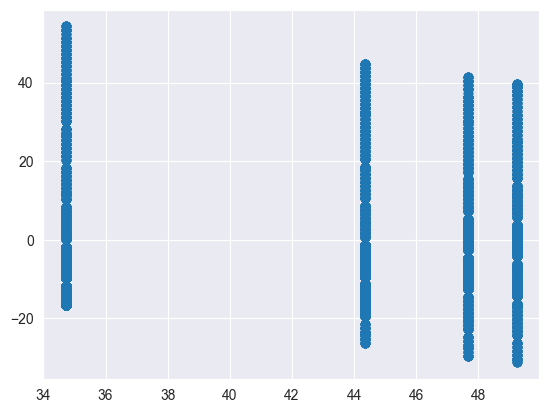

(10593,)

In [54]:
print(shapiro(model_two_way.resid))

# TODO попытка строить scatter для Шапиро
pred = model.predict()

X = pred 
Y = model.resid

plt.scatter(X, Y)
plt.show()

Y.shape



QQ - plot two_way

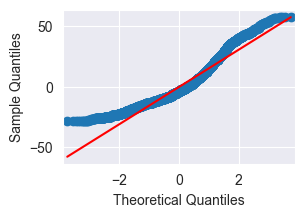

In [38]:
fig, axes = plt.subplots(figsize=(3, 2))
sm.qqplot(model_two_way.resid, line='s', ax=axes)
plt.show()

 post hoc ◾ Тьюки  two-way
 * Н0 - между средними групп различий нет

In [28]:
# TODO Добавляем столбец 'Combi' для pairwise_tukeyhsd
df_cs['Combi'] = df_cs.Segmentation + '/' + df_cs.Graduated
# df_cs

In [29]:
tukey_to_way = pairwise_tukeyhsd(endog=df_cs.Age, groups=df_cs.Combi, alpha=0.05)
tukey_to_way.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A/No,A/Yes,1.3896,0.2931,-0.4414,3.2206,False
A/No,B/No,2.8664,0.0037,0.5767,5.1561,True
A/No,B/Yes,4.6981,0.0,2.8575,6.5387,True
A/No,C/No,0.2673,1.0,-2.3012,2.8358,False
A/No,C/Yes,7.1141,0.0,5.3191,8.9092,True
A/No,D/No,-12.5708,0.0,-14.3916,-10.7499,True
A/No,D/Yes,-3.1845,0.0,-5.1587,-1.2103,True
A/Yes,B/No,1.4768,0.3962,-0.6262,3.5798,False
A/Yes,B/Yes,3.3085,0.0,1.7061,4.9109,True
A/Yes,C/No,-1.1223,0.8505,-3.5258,1.2813,False


levene ◾ TWO-WAY

In [ ]:
# TODO группируем df по элементам признаков Segmentation' и 'Graduated, извлекаем имена и под-таблицы
groups = []
for grp_name, data in df_cs.groupby(['Segmentation', 'Graduated']):
  groups.append(data.Age)
  print(grp_name)

In [ ]:

lev = stats.levene(*groups)
print(lev, '\n')


pingouin one-way


In [ ]:
# Объединяем данные в один DataFrame
df_long = df_cs[['Age', 'Segmentation']]  # Age — числовой, Segmentation — группы

welch_anova = pg.welch_anova(dv='Age', between='Segmentation', data=df_long)
print(welch_anova)

pingouin two-way

In [ ]:
# TODO Pingouin делает взаимодействие факторов автоматически в стандартной pg.anova(), если  оба фактора в between.
# Без взаимодействия факторов:
anova_two_way = pg.anova(dv='Age', between=['Segmentation', 'Graduated'], data=df_cs)
print(anova_two_way)